In [ ]:
import pm4py
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Add the Graphviz bin directory to the PATH environment variable
graphviz_path = 'C:\\Program Files\\Graphviz\\bin'  # Adjust this path to where Graphviz is installed on your system
os.environ['PATH'] = graphviz_path + os.pathsep + os.environ['PATH']

import graphviz

In [5]:
data=pd.read_pickle("../../data/data_transformed_cleaned.pkl")

In [7]:
# build and activity dataset 
data=data[['user_id', 'platform', 'activity_type',"timestamp_converted"]]
data.columns=['case_id', 'org:resource','activity', 'timestamp']

In [ ]:
## platform based
df_new=data.drop_duplicates(["case_id", "org:resource"])
df_new_1=df_new.groupby("case_id").count().reset_index()


In [11]:
# focusing on people who has done something on all four platforms 
users=df_new_1[df_new_1.activity==4].case_id.to_list()
m_users=data[data.case_id.isin(users)].reset_index(drop=True)

In [202]:
#m_users.to_csv("user_samples.csv", index=False)

**multi platform users**

In [12]:
m_users.groupby(["org:resource", "activity"]).count().sort_values(["org:resource", "case_id"])

case_id  timestamp
org:resource activity                                                         
facebook     links_in_pms                                         1          1
             friends                                             16         16
             group_activities                                    24         24
             likes_and_follows                                   38         38
             posts                                               79         79
             reactions                                          562        562
             last_seen_profiles_events_groups_marketplaces      605        605
             last_seen_content                                 1742       1742
             searches                                          2439       2439
instagram    login_history                                        4          4
             search_history                                      11         11
             follower                                            28         28
             saved_posts                                         33         33
             comment_history                                     54         54
             following                                           71         71
             shared_links                                       245        245
             likes                                             8889       8889
tiktok       blocked                                              2          2
             post_history                                         2          2
             gifts_made                                          12         12
             watched_livestreams                                 19         19
             followers                                           84         84
             following                                          141        141
             favorite_videos_effects_hashtags_sounds            160        160
             shared_videos                                      207        207
             search_history                                     477        477
             login_history                                     2135       2135
             watched_videos                                   33840      33840
youtube      search_history                                     405        405
             watch_history                                     6874       6874

In [15]:
### some key activities 
df_filter1=[
 'likes_and_follows',
 'posts',
 'reactions',
 'last_seen_content',
 'searches',
 'search_history',
 'saved_posts',
 'comment_history',
 'shared_links',
 'likes',
 'favorite_videos_effects_hashtags_sounds',
 'shared_videos',
 'search_history',
 'watched_videos',
 'search_history',
 'watch_history']

In [16]:
m_users=m_users[m_users.activity.isin(df_filter1)].reset_index(drop=True)

In [17]:
m_users["activity"]=m_users["activity"]+" ("+m_users["org:resource"] +")"

**daily rountine**

In [ ]:
### some more processing for creating the case_id_day
df=m_users.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
# date from the timestamp
df['date'] = df['timestamp'].dt.date
# day modifiers by grouping by user id
df['day_modifier'] = df.groupby('case_id')['date'].rank(method='dense').astype(int)
df['case_id_day'] = df['case_id'].astype(str) + '_day' + df['day_modifier'].astype(str)


In [ ]:
## get duration 
def process_user_data(df):
    processed = []
    df = df.sort_values(by=['timestamp']).drop_duplicates("timestamp")
    for index, row in df.iterrows():
        if processed:
            last_activity = processed[-1] # make reference to the last activity dictionary
            if last_activity['activity'] == row['activity']:
                last_activity['end_time'] = row['timestamp']
            elif any(prev['activity'] == row['activity'] and (row['timestamp'] - prev['end_time']).total_seconds() <= 2 for prev in processed):
                for prev in processed:
                    if prev['activity'] == row['activity'] and (row['timestamp'] - prev['end_time']).total_seconds() <= 2:
                        prev['end_time'] = row['timestamp']
                        break
            else:
                new_activity = row.to_dict()
                new_activity['start_time'] = row['timestamp']
                new_activity['end_time'] = row['timestamp']
                processed.append(new_activity)
        else:
            new_activity = row.to_dict()
            new_activity['start_time'] = row['timestamp']
            new_activity['end_time'] = row['timestamp']
            processed.append(new_activity)
    if processed:
        for activity in processed:
            activity['duration'] = (activity['end_time'] - activity['start_time']).total_seconds() / 60 # mins
    return pd.DataFrame(processed)


In [21]:
grouped = df.sort_values(by=[ 'timestamp', "case_id_day"]).groupby(['case_id_day'])
data_duration=pd.concat([process_user_data(group) for _, group in grouped])


In [22]:
# get platform switch
def platform_switch(df):
    df['platform_switch'] = df['org:resource'] != df.groupby('case_id_day')['org:resource'].shift()
    new_data = []
    for idx, row in df.iterrows():
        new_data.append(row)
        try:
            if idx>0 and row['platform_switch']:
                new_row = row.copy()
                new_row['platform'] = df.loc[idx, 'org:resource']
                new_row['activity'] = f"platform_switch"

                new_row['timestamp'] = row['timestamp'] - pd.Timedelta(seconds=1)
 
                new_data.append(new_row)
        except:
            pass

    df_expanded = pd.DataFrame(new_data).sort_values(by=['timestamp', 'case_id_day']).reset_index(drop=True)
    df_expanded = df_expanded.drop(columns=['platform_switch'])
    return df_expanded

In [23]:
grouped = data_duration.groupby(['case_id_day'])
data_switch=pd.concat([platform_switch(group.reset_index(drop=True)) for _, group in grouped]).reset_index(drop=True)

In [ ]:
data_duration.iloc[0] # example 

case_id                284269849241742
org:resource                    tiktok
activity        shared_videos (tiktok)
timestamp          2024-05-01 13:47:33
date                        2024-05-01
day_modifier                         1
case_id_day       284269849241742_day1
start_time         2024-05-01 13:47:33
end_time           2024-05-01 13:59:30
duration                         11.95
Name: 0, dtype: object

In [42]:
# sort data by case_id_day and timestamp
df=data_switch.copy()
df = df.sort_values(by=['case_id_day', 'start_time'])

# Check if consecutive activities are the same by comparing each activity with the previous one within the same 'case_id_day'
df['same_consecutive_behavior'] = df['activity'] == df.groupby('case_id_day')['activity'].shift()

# Filter rows where the consecutive behavior is the same
same_behavior_df = df[df['same_consecutive_behavior'] == True]

# Drop unnecessary columns for final output
same_behavior_df[['case_id_day', 'timestamp', 'activity']]

,case_id_day,timestamp,activity


In [ ]:
df.to_csv("sample.csv", index=False) ## save the processed data 


Next, we switch to the process mining toolkit,[ ProM Lite 1.4](https://promtools.org/), to explore the processual patterns in the subset of multi-platform user-sequences. 

In [ ]:
## get the output from ProM and plot it 
a = pd.read_csv("../../data/duration_time.csv")

In [ ]:
platforms=['Facebook', 'Instagram','TikTok', 'YouTube']
df=pd.DataFrame(a, columns=platforms)
df.index=platforms

In [ ]:
## plot it
fig, ax=plt.subplots(figsize=(6,4
                            )) 
g=sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,  fmt='g', annot_kws={"fontsize":11}, cmap= matplotlib.cm.get_cmap('rocket_r'),linewidths=1.5)
g.set_yticklabels(g.get_yticklabels(), rotation =0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

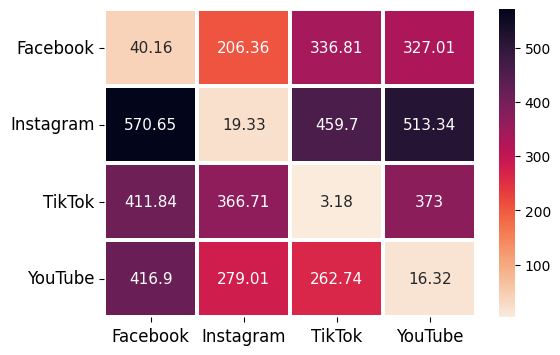

In [40]:
fig

Next, we used pm4py to build and explore process models.
- For more details, see [PM4Py: A process mining library for Python](https://www.sciencedirect.com/science/article/pii/S2665963823000933). In *Software Impacts* (pp. 1-7).
- For tutorial, see [pm4py](https://github.com/process-intelligence-solutions/pm4py). 

In [ ]:
# filter number of activities per day
filter_activity=df.groupby("case_id_day").count().reset_index()
filter_days=filter_activity[filter_activity.case_id<100][filter_activity.case_id>3].case_id_day.to_list()

In [44]:
filter_log=df[df.case_id_day.isin(filter_days)].reset_index(drop=True)

In [45]:
# format the df in pm4py
df_tt = pm4py.format_dataframe(filter_log, case_id='case_id_day',activity_key='activity',
                             timestamp_key='timestamp')
df_tt['time:timestamp'] = pd.to_datetime(df_tt['time:timestamp'])

In [ ]:
### filter the top ten routes
filtered_log = pm4py.filter_variants_top_k(df_tt, 10)

In [48]:
filtered_log["org:resource"].unique()

array(['facebook', 'tiktok', 'instagram', 'youtube'], dtype=object)

In [50]:
bpmn_model = pm4py.discover_bpmn_inductive(filtered_log, 0.8)

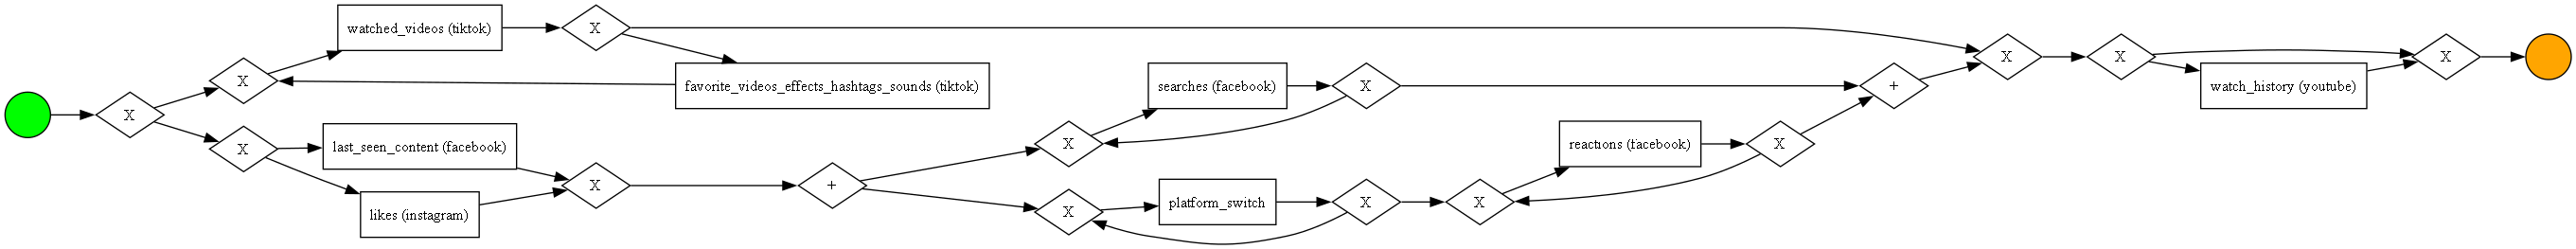

In [51]:
pm4py.view_bpmn(bpmn_model)

In [52]:
import pm4py
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer

# Assuming bpmn_model is already obtained as follows:
# filtered_log = your_method_to_filter_log(raw_log)
# bpmn_model = pm4py.discover_bpmn_inductive(filtered_log, 0.8)

# Define color dictionary
color_dict = {'instagram': "#feab46", 'facebook': "#4389c1", 'tiktok': "#8c8c8c", "youtube": "#df570f"}

# Initialize a dictionary to hold the color mapping for activities
activity_color_dict = {}

# Iterate through the activities in the BPMN model to assign colors
for flow_element in bpmn_model.get_nodes():
    # Check if node has a name attribute that includes the platform name
    if hasattr(flow_element, 'name'):
        for platform in color_dict:
            if f'({platform})' in flow_element.name:
                activity_color_dict[flow_element] = color_dict[platform]
                print(flow_element)




id8bc0c702-0bd0-4338-b66f-3fcabeb3db4b@last_seen_content (facebook)
ide96b70ed-0924-46ff-84ee-026087debd5c@searches (facebook)
ide8a88079-ff7e-4e2e-b4dd-8324bd212501@favorite_videos_effects_hashtags_sounds (tiktok)
id8a184b52-ee51-42f1-940a-2a3e192193f3@watch_history (youtube)
idf5974745-8efe-4403-935f-a9f19ce76390@likes (instagram)
ide1b72013-4698-4c23-bf90-ece6e3c4841f@reactions (facebook)
idb0a52b80-e05e-448b-aad2-db2979fd7abe@watched_videos (tiktok)


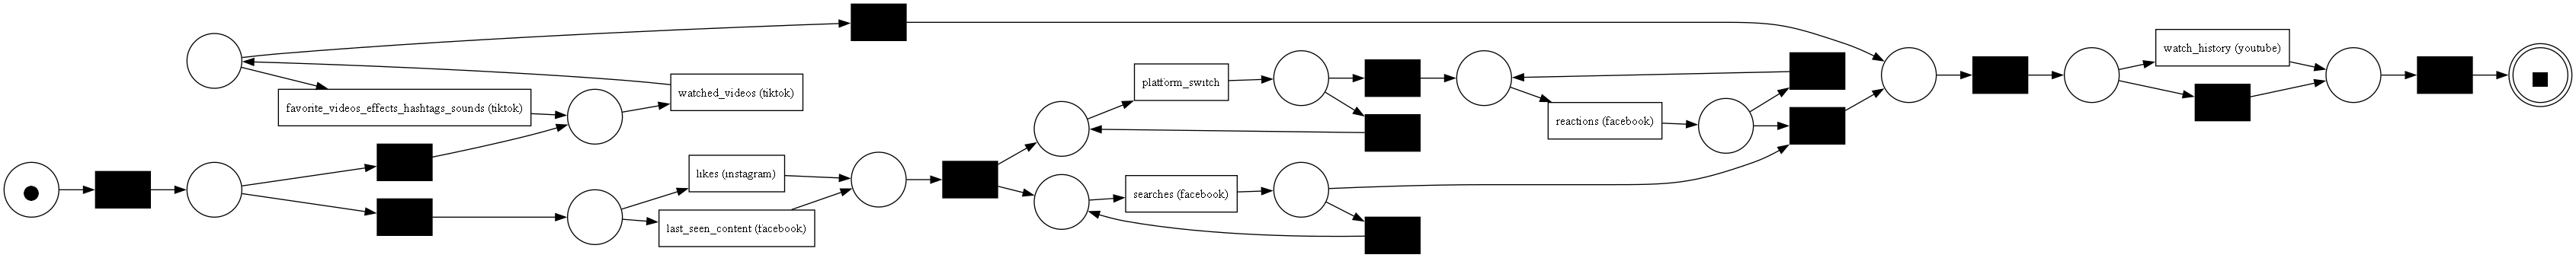

In [55]:
net1, im1, fm1 = pm4py.convert_to_petri_net(bpmn_model)
pm4py.view_petri_net(net1,im1,fm1)

In [56]:
filtered_log['case:concept:name'].nunique()

21

In [57]:
filtered_log["concept:name"].value_counts()

concept:name
searches (facebook)                                 32
platform_switch                                     28
likes (instagram)                                   16
watched_videos (tiktok)                             14
reactions (facebook)                                12
last_seen_content (facebook)                         8
favorite_videos_effects_hashtags_sounds (tiktok)     4
watch_history (youtube)                              2
search_history (youtube)                             2
Name: count, dtype: Int64

In [58]:
filtered_log.groupby(["case:concept:name", "concept:name"]).first().reset_index()["concept:name"].value_counts()

concept:name
platform_switch                                     18
searches (facebook)                                 17
likes (instagram)                                   14
watched_videos (tiktok)                             10
last_seen_content (facebook)                         5
favorite_videos_effects_hashtags_sounds (tiktok)     4
reactions (facebook)                                 4
watch_history (youtube)                              2
search_history (youtube)                             2
Name: count, dtype: Int64

In [59]:
filtered_log.groupby("case:concept:name").first()["concept:name"].value_counts()

concept:name
likes (instagram)               14
last_seen_content (facebook)     3
searches (facebook)              2
watched_videos (tiktok)          2
Name: count, dtype: Int64

In [60]:
filtered_log.groupby("case:concept:name").last()["concept:name"].value_counts()

concept:name
watched_videos (tiktok)    10
searches (facebook)         7
likes (instagram)           2
watch_history (youtube)     2
Name: count, dtype: Int64

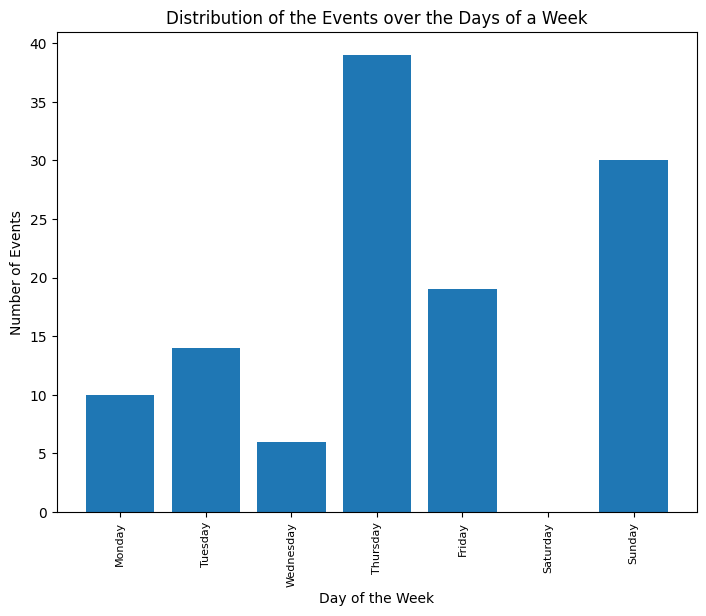

In [61]:
pm4py.view_events_distribution_graph(filtered_log, distr_type="days_week") # Matplotlib inside!

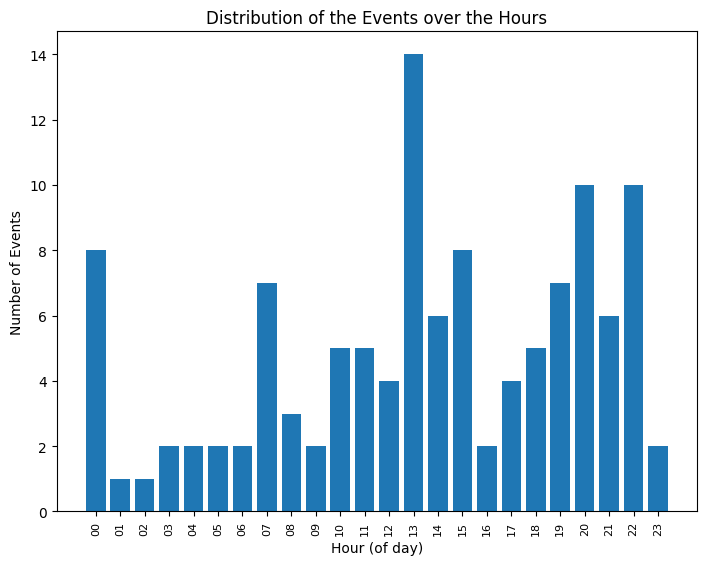

In [62]:
pm4py.view_events_distribution_graph(filtered_log, distr_type="hours") # Matplotlib inside!

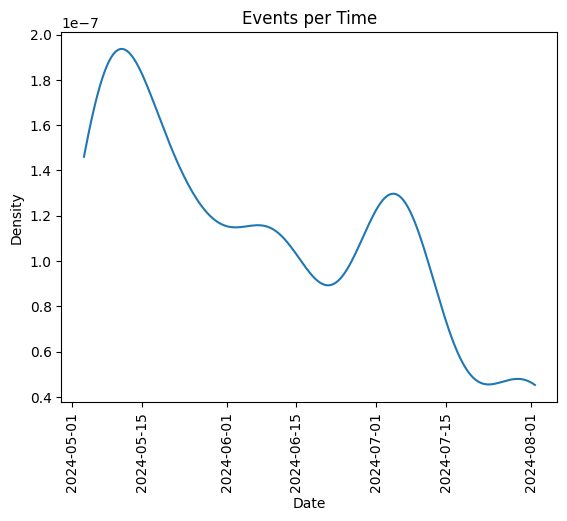

In [63]:
pm4py.view_events_per_time_graph(filtered_log) # Matplotlib inside!

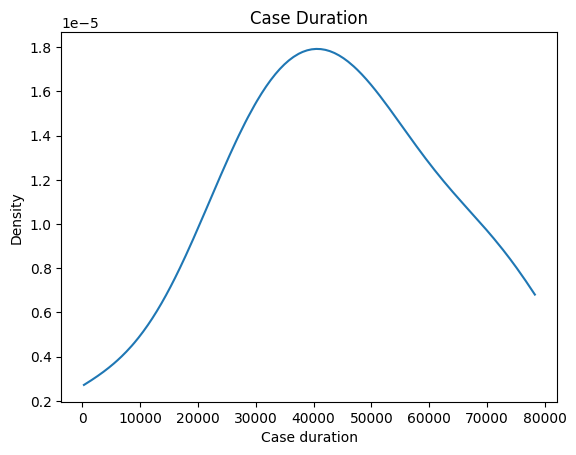

In [64]:
pm4py.view_case_duration_graph(filtered_log) # Matplotlib inside!

In [73]:
dfg = pm4py.discover_dfg(filtered_log)
print(dfg[0]) # graph structure

{('favorite_videos_effects_hashtags_sounds (tiktok)', 'watched_videos (tiktok)'): 4, ('last_seen_content (facebook)', 'searches (facebook)'): 8, ('likes (instagram)', 'platform_switch'): 14, ('platform_switch', 'favorite_videos_effects_hashtags_sounds (tiktok)'): 2, ('platform_switch', 'likes (instagram)'): 2, ('platform_switch', 'reactions (facebook)'): 2, ('platform_switch', 'search_history (youtube)'): 2, ('platform_switch', 'searches (facebook)'): 10, ('platform_switch', 'watch_history (youtube)'): 2, ('platform_switch', 'watched_videos (tiktok)'): 8, ('reactions (facebook)', 'searches (facebook)'): 12, ('search_history (youtube)', 'platform_switch'): 2, ('searches (facebook)', 'last_seen_content (facebook)'): 5, ('searches (facebook)', 'platform_switch'): 10, ('searches (facebook)', 'reactions (facebook)'): 10, ('watched_videos (tiktok)', 'favorite_videos_effects_hashtags_sounds (tiktok)'): 2, ('watched_videos (tiktok)', 'platform_switch'): 2}


In [66]:
print(dfg[1]) # start activities

{'searches (facebook)': 2, 'last_seen_content (facebook)': 3, 'likes (instagram)': 14, 'watched_videos (tiktok)': 2}


In [67]:
print(dfg[2]) # end activities

{'watched_videos (tiktok)': 10, 'searches (facebook)': 7, 'likes (instagram)': 2, 'watch_history (youtube)': 2}


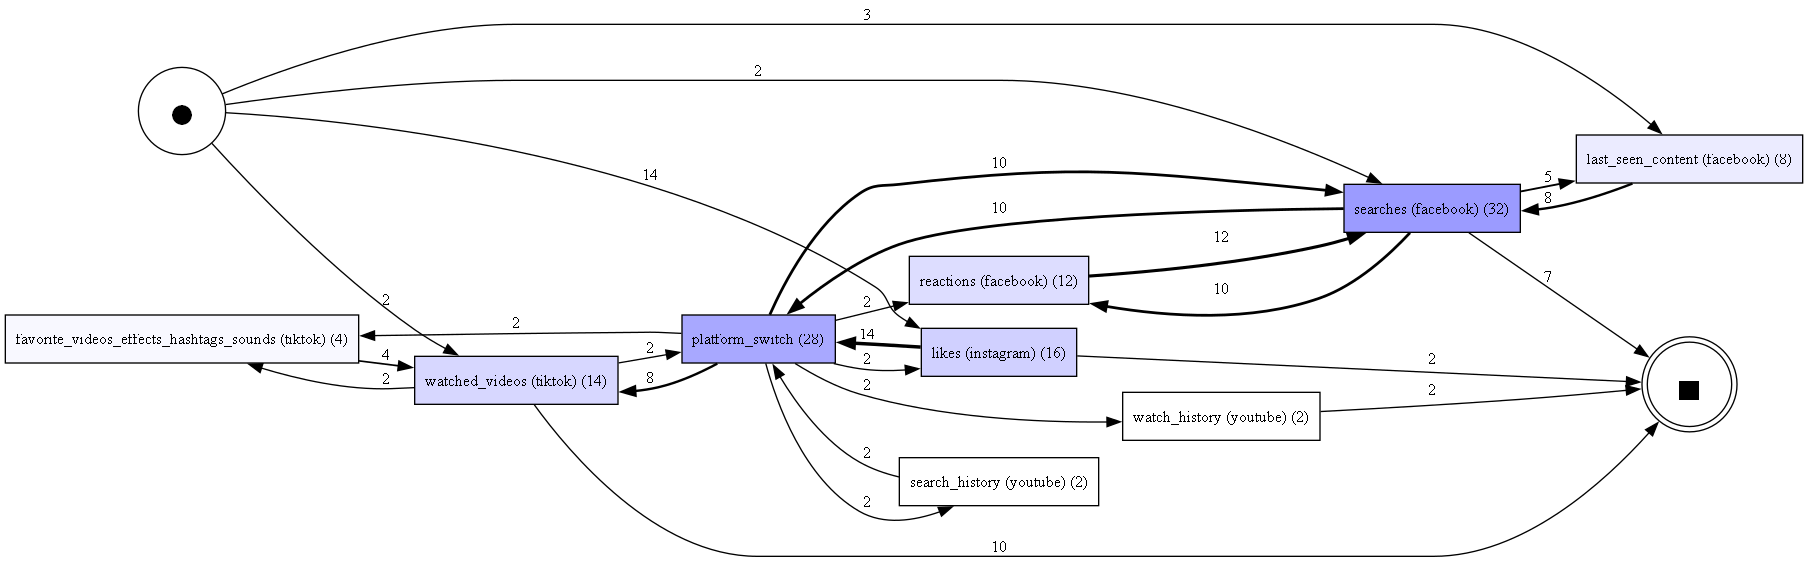

In [68]:
pm4py.view_dfg(dfg[0], dfg[1], dfg[2])

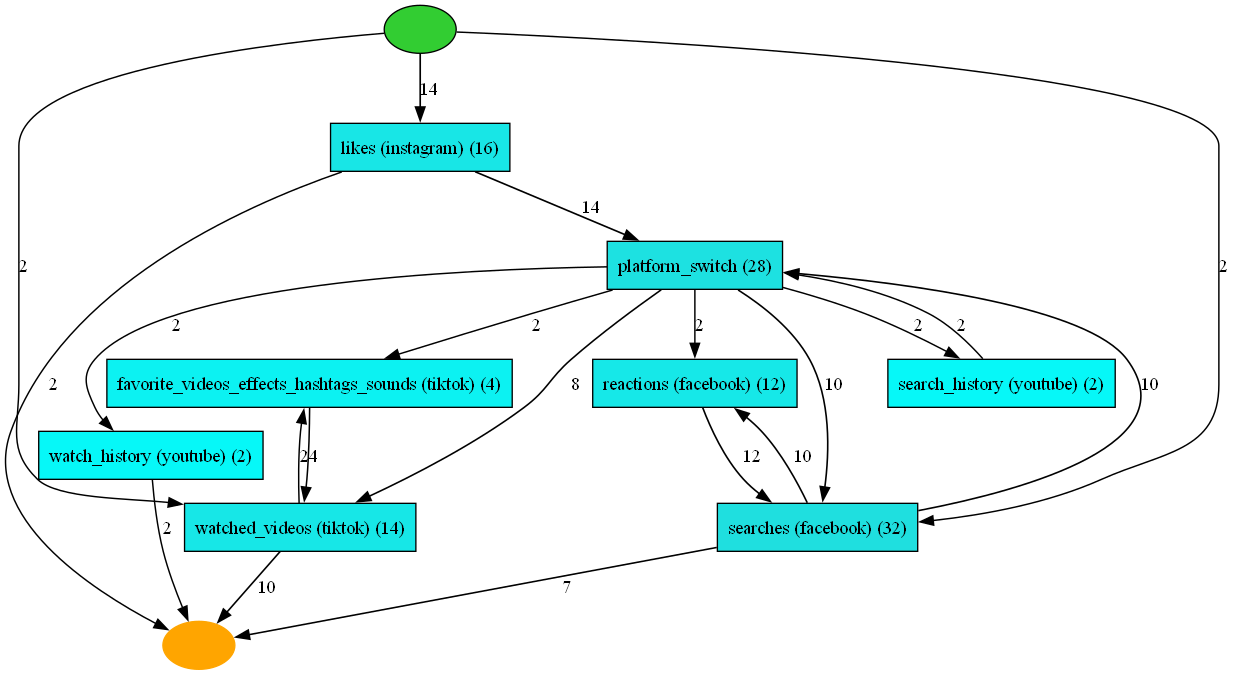

In [69]:
map = pm4py.discover_heuristics_net(filtered_log)
pm4py.view_heuristics_net(map)

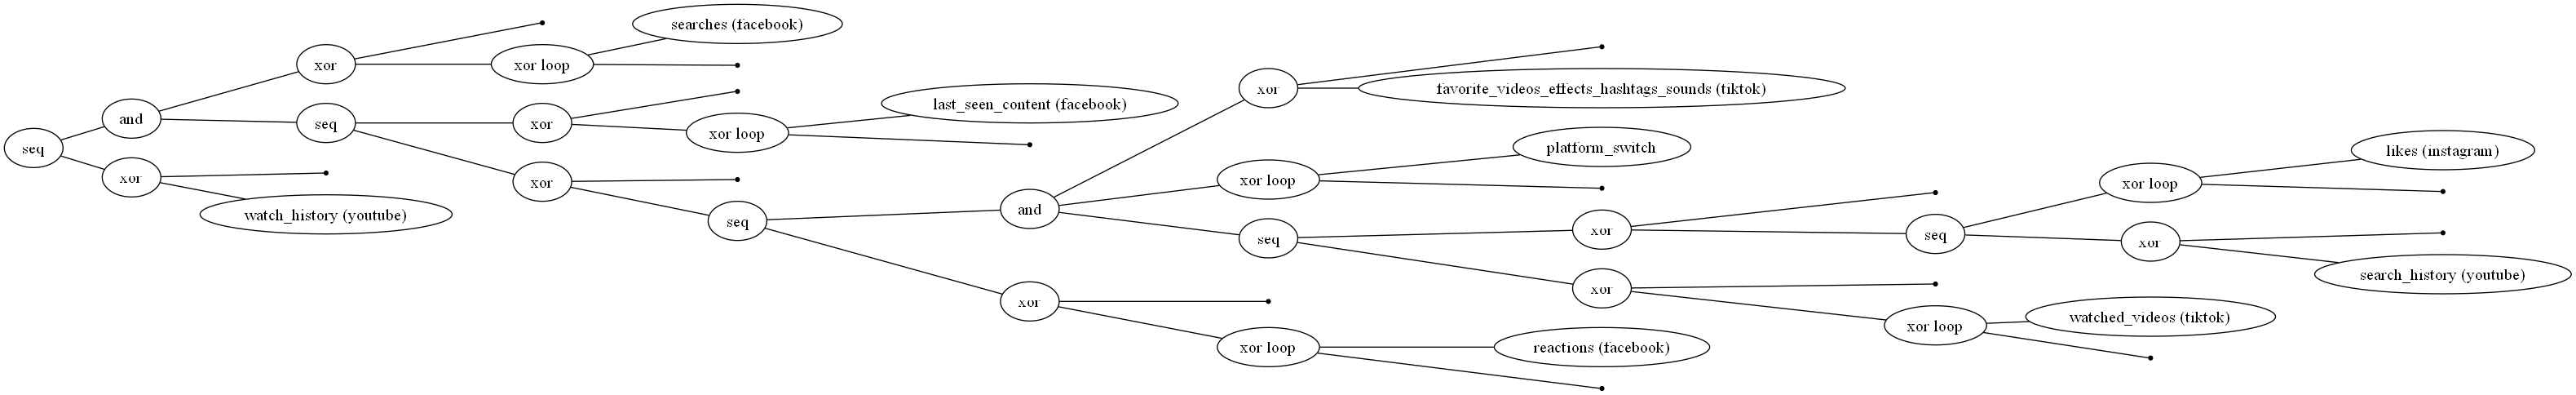

In [70]:
process_tree = pm4py.discover_process_tree_inductive(filtered_log)
pm4py.view_process_tree(process_tree)